# Capstone Modeling Script

In [1]:
#Import general data manipulation/plotting packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
import pickle

#Import data preprocessing packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#Import train/test and cross validation packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

#Import regression packages
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels import regression
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#Import random forest package
from sklearn.ensemble import RandomForestRegressor

#Import scoring metrics
from sklearn.metrics import mean_squared_error

#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
current_path = % pwd
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..

D:\Coding Projects\Springboard\Springboard_Projects\Capstone


In [3]:
#Import data

#Read in AirBnB dataset that has been merged with summarized Yelp information:
#... (number of businesses, total reviews, and average star rating for businesses w/in .1 and .5 miles)
path1='../Capstone/Data/abb_stat_inf_changes.csv'
abb = pd.read_csv(path1)

print(abb.shape)
abb.head()

(16011, 73)


,id,host_response_time,host_response_rate,host_is_superhost,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,instant_bookable,cancellation_policy,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA,has_Wifi,has_Heating,has_Essentials,has_Kitchen,has_Smoke_detector,has_Air_conditioning,has_Hangers,has_Washer,has_Dryer,has_Shampoo,has_TV,has_Familykid_friendly,has_Elevator,has_Free_parking_on_premises,has_Internet,has_Gym,has_Cable_TV,has_Paid_parking_off_premises,has_Pool,has_Hot_tub,has_Pets_allowed,has_Breakfast,has_Buzzerwireless_intercom,has_Indoor_fireplace,has_Free_street_parking,has_Wheelchair_accessible,has_Doorman,has_Pets_live_on_this_property,has_Smoking_allowed,host_lives_near_listing,yelp_bus_count_1,yelp_bus_total_reviews_1,yelp_bus_avg_rating_1,yelp_bus_count_5,yelp_bus_total_reviews_5,yelp_bus_avg_rating_5,log_price,Utilization_Rate
0,1419,within an hour,0.0,f,Little Portugal,House,Entire home/apt,6.0,2.0,3.0,4.0,Real Bed,470.0,1000.0,150.0,1.0,0.0,4.0,f,strict_14_with_grace_period,True,False,True,True,True,True,True,True,False,True,True,True,True,False,True,True,False,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,66.0,3.50,116.0,8634.0,3.758621,6.152733,0.013053
1,10314,within an hour,0.0,f,Riverdale,House,Private room,2.0,1.0,1.0,1.0,Real Bed,69.0,0.0,0.0,2.0,20.0,1.0,f,moderate,False,True,True,True,True,True,False,False,False,True,True,True,True,False,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,4.234107,0.042601
2,12604,within an hour,0.0,f,The Annex,House,Private room,1.0,1.5,1.0,1.0,Pull-out Sofa,65.0,130.0,26.0,1.0,20.0,1.0,f,moderate,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,NaN,NaN,NaN,11.0,1631.0,3.045455,4.174387,0.000866
3,17936,within an hour,100.0,t,Kensington Market,Apartment,Private room,4.0,1.0,1.0,2.0,Real Bed,99.0,300.0,80.0,1.0,20.0,2.0,f,strict_14_with_grace_period,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,20.0,1440.0,3.65,160.0,11434.0,3.715625,4.595120,0.105691
4,23691,within an hour,100.0,t,Wychwood,House,Private room,2.0,1.0,1.0,1.0,Real Bed,70.0,0.0,0.0,2.0,25.0,1.0,t,strict_14_with_grace_period,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,NaN,NaN,NaN,11.0,147.0,3.363636,4.248495,0.092562


## Drop Unecessary Variables

### Drop Uneeded Amenities
Earlier in the Statistical Inference script I ran a series of t-tests to determine whether each Amenity has a statistically significant relationship to Price and/or Utilization Rate.

I plan to drop Amenities that did not have a statistically significant relationship. My desired p-value to determine statistical significance is 0.05. However I know that when making multiple comparisons, it is often very easy to have tests that pass the threshold purely by chance. The Bonferroni correction is a simple way to avoid this issue. 

The number of comparisons being made is 29, so I know my actual p-value threshold needs to be (0.05/29=) 0.0017. I will drop any amenities that did not pass that threshold. 

Note: There were differences in which Amenities were statistically significant against Price vs. Utilization Rate. At this point I will create two datasets, one to predict Price, the other Utilization Rate, so I can keep the variables with the best relationship to each outcome. 

In [4]:
#Create copies of dataset
abb_Price_predict = abb.copy()

In [5]:
abb_Util_predict = abb.copy()

In [6]:
#Drop amenity variables with a p-value greater than 0.0017 from Price prediction dataset
drop_cols = ['has_Wifi', 'has_Doorman', 'has_Indoor_fireplace', 'has_Familykid_friendly', 'has_Wheelchair_accessible',
            'has_Hot_tub', 'has_Hangers', 'has_Buzzerwireless_intercom', 'has_Shampoo']

abb_Price_predict.drop(columns=drop_cols, axis=1, inplace=True)

abb_Price_predict.shape

(16011, 64)

In [7]:
#Drop amenity variables with a p-value greater than 0.0017 from Utilization_Rate prediction dataset
drop_cols = ['has_Hangers', 'has_Smoking_allowed', 'has_Pool', 'has_Hot_tub', 'has_Air_conditioning', 'has_Elevator',
            'has_Gym', 'has_Familykid_friendly', 'has_Free_parking_on_premises', 'has_Smoke_detector', 'has_Wheelchair_accessible',
            'has_Pets_allowed', 'has_Indoor_fireplace', 'has_Paid_parking_off_premises', 'has_Breakfast', 'has_Doorman',
            'has_Essentials', 'has_Free_street_parking', 'has_Pets_live_on_this_property', 'has_Shampoo', 'has_Buzzerwireless_intercom']

abb_Util_predict.drop(columns=drop_cols, axis=1, inplace=True)

abb_Util_predict.shape

(16011, 52)

### Drop Uneeded "NA" Flag Variables

Now I will do the same for the \_notNA variables, which are flag variables I created during data wrangling to tell me if a value was missing for a given variable. I did a series of t-tests on these against Price and Utilization to see which had a statistically significant relationship. 

This time the number of comparisons was 10, so the p-value threshold they need to pass for significance is (0.05/10=) 0.005.

Note: Technically there were 15 \_notNA variables tested in the Statistical Inference script, but this was a mistake. 5 of those had no NA values (likely the records with missing values were dropped over time for those) so they had no actual data to test. Those variables will be dropped below as well. 

In [8]:
#Drop _notNA variables with a p-value greater than 0.0017 from Price prediction dataset
drop_cols = ['bathrooms_notNA', 'beds_notNA', 'bedrooms_notNA', 'neighbourhood_cleansed_notNA', 'host_is_superhost_notNA',
            'monthly_price_notNA', 'weekly_price_notNA', 'neighbourhood_notNA', 'host_response_rate_notNA', 'host_response_time_notNA',
            'host_neighbourhood_notNA', 'square_feet_notNA']

abb_Price_predict.drop(columns=drop_cols, axis=1, inplace=True)

abb_Price_predict.shape

(16011, 52)

In [9]:
#Drop _notNA variables with a p-value greater than 0.0017 from Utilization Rate prediction dataset
drop_cols = ['bathrooms_notNA', 'beds_notNA', 'bedrooms_notNA', 'neighbourhood_cleansed_notNA', 'host_is_superhost_notNA',
            'square_feet_notNA', 'weekly_price_notNA', 'host_neighbourhood_notNA', 'monthly_price_notNA']

abb_Util_predict.drop(columns=drop_cols, axis=1, inplace=True)

abb_Util_predict.shape

(16011, 43)

### Drop Yelp Business Metrics w/out Statistical Significance, Create Flag Variables for Having a Business w/in .1 and .5 Miles

Next I will drop the Yelp Business metrics that did not show a statistically significant correlation with Price/Utilization (or if the correlation was extremely low). 

As a reminder, the Yelp Business metrics are Number of Businesses, Total Reviews, and Avg. Star Rating. These were calculated for all businesses within .1 and .5 miles of each AirBnB listing, for 6 variables total. 

All three of the metrics for busineses within .1 mile had a very low correlation with both Price and Utilization. I will drop all three of the .1 mile metrics. However when doing a t-test comparing the Price of listings with at least one business within .1 mile and those that did not, there was a large and statistically significant price difference (same for those with/without businesses within .5 mile). So before dropping the .1 mile metrics I will create a flag variable that is True if the AirBnB listing has a business within .1 (and .5) miles.

In [10]:
#Create flag variable indicating if any business was within .1, .5 miles of an AirBnB listing
abb_Price_predict['Bus_in_pt_1'] = pd.notna(abb_Price_predict['yelp_bus_count_1'])
abb_Price_predict['Bus_in_pt_5'] = pd.notna(abb_Price_predict['yelp_bus_count_5'])

In [11]:
abb_Util_predict['Bus_in_pt_1'] = pd.notna(abb_Util_predict['yelp_bus_count_1'])
abb_Util_predict['Bus_in_pt_5'] = pd.notna(abb_Util_predict['yelp_bus_count_5'])

In [13]:
#Drop .1 mile Yelp Business variables
drop_cols = ['yelp_bus_count_1', 'yelp_bus_total_reviews_1', 'yelp_bus_avg_rating_1']

abb_Price_predict.drop(columns=drop_cols, axis=1, inplace=True)
print(abb_Price_predict.shape)

(16011, 51)


In [14]:
#Drop .1 mile Yelp Business variables
drop_cols = ['yelp_bus_count_1', 'yelp_bus_total_reviews_1', 'yelp_bus_avg_rating_1']
abb_Util_predict.drop(columns=drop_cols, axis=1, inplace=True)                       
print(abb_Util_predict.shape)

(16011, 42)


The .5 mile Yelp Business metrics, specifically Number of Businesses and Total Reviews, did show both a practical correlation coefficient and statistical significance when compared to Price, so those variables will be kept in the Price prediction dataset. The Avg. Rating was not practically significant against Price, so it will be dropped.

All three .5 mile Yelp Business metrics were not practically significant against Utilization Rate and will be dropped. 

In [15]:
#Drop .5 mile Yelp Business variables from price prediction dataset
drop_cols = ['yelp_bus_avg_rating_5']

abb_Price_predict.drop(columns=drop_cols, axis=1, inplace=True)

print(abb_Price_predict.shape)

(16011, 50)


In [16]:
#Drop .5 mile Yelp Business variables from utilization prediction dataset
drop_cols = ['yelp_bus_count_5', 'yelp_bus_total_reviews_5', 'yelp_bus_avg_rating_5']

abb_Util_predict.drop(columns=drop_cols, axis=1, inplace=True)

print(abb_Util_predict.shape)

(16011, 39)


As a final step I will replace NaN values in the Yelp metrics with 0 to ensure the modeling algorithms do not drop those records.

In [17]:
abb_Price_predict[['yelp_bus_count_5', 'yelp_bus_total_reviews_5']] = abb_Price_predict[['yelp_bus_count_5', 'yelp_bus_total_reviews_5']].fillna(0.0)

## Predicting Price

### Produce Baseline Price Prediction Model
First I will create a simple baseline linear regression model predicting raw price (not log price) with all of the predictor variables. This will serve as my baseline model to compare future models against. Before doing that I need to convert my categorical predictor variables into binary flag variables, then split my data into train test splits. I will also scale my numeric variables, but I will handle that within the modeling pipeline. Scaling is not necessarily a requirement for standard linear regression, but I know I will use Ridge, Lasso, Random Forest, and possibly other model types later on that will require scaled numeric variables. 

In [18]:
#Perform get_dummies to one-hot encode categorical variables
cat_cols = abb_Price_predict[['host_response_time', 'neighborhood', 'host_is_superhost', 'room_type', 'bed_type',
                            'instant_bookable', 'cancellation_policy', 'property_type']].columns

abb_Price_predict_expanded = abb_Price_predict.copy()
abb_Price_predict_expanded = pd.get_dummies(abb_Price_predict, sparse=True, columns=cat_cols, drop_first=True)

#Confirm only numeric variables remain
abb_Price_predict_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16011 entries, 0 to 16010
Columns: 107 entries, id to property_type_Townhouse
dtypes: bool(26), float64(15), int64(1), uint8(65)
memory usage: 2.4 MB


In [19]:
#Create X and y
X_vars = abb_Price_predict_expanded.columns.difference(['id', 'price', 'Utilization_Rate', 'log_price'])
X = abb_Price_predict_expanded[X_vars]
y = abb_Price_predict_expanded[['price', 'log_price', 'Utilization_Rate']]

In [20]:
#Create train-test split
X_train, X_test, y_train,  y_test = train_test_split(X, y, 
                                                     test_size = 0.3, 
                                                     random_state=17)

Next I will create a pipeline that handles scaling and modeling in one step. I will use MinMax instead of Standard scaler because I know most of my numeric variables do not follow a normal distribution, and are in fact skewed right (long tail to the right). 

In [21]:
#Initialize MinMaxScaler
scaler = MinMaxScaler()
#Initialize Linear Regression
regression = LinearRegression()
#Create pipeline
pipeline_ols = Pipeline([("Scaler", scaler), ("Regression", regression)])

In [22]:
pipeline_ols.fit(X_train, y_train['price'])

Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [23]:
#Calculate R^2 on train and test sets
ols_r2_train = pipeline_ols.score(X_train, y_train['price'])
ols_r2_test = pipeline_ols.score(X_test, y_test['price'])

In [24]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = pipeline_ols.predict(X_train)
x_test_pred = pipeline_ols.predict(X_test)

mse_train = mean_squared_error(y_train['price'], x_train_pred)
mse_test = mean_squared_error(y_test['price'], x_test_pred)

In [25]:
scores_df = pd.DataFrame([{'Model':'OLS_RawPrice', 'R2_train':ols_r2_train, 'R2_test':ols_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}])

In [26]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']]

,Model,R2_train,R2_test,MSE_train,MSE_test
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468


In [27]:
coefficients = pd.DataFrame({"Feature":X_train.columns, 
                             "Coefficients_RawPrice":np.transpose(pipeline_ols.named_steps['Regression'].coef_)})

coefficients[coefficients['Coefficients_RawPrice']!=0].count()

Feature                  103
Coefficients_RawPrice    103
dtype: int64

In [28]:
coefficients

,Feature,Coefficients_RawPrice
0,Bus_in_pt_1,3.079987
1,Bus_in_pt_5,3.821984
2,accommodates,42.976319
3,bathrooms,29.090275
4,bed_type_Couch,21.674247
5,bed_type_Futon,-2.895998
6,bed_type_Pull-out Sofa,-0.748246
7,bed_type_Real Bed,2.978937
8,bedrooms,62.451866
9,beds,13.859300


My model has many input variables, 111 with a coefficient not equal to 0 (which is all of the variables). Feature selection will need to be performed to fine-tune this model. 

Interestingly the R2 value is decent and actually improves from train to test (0.49 to 0.5). Mean Squared Error slightly increases from train to test. Higher is better for R2, lower is better for MSE. 

Next I will try running the same model on 

### Fit Model on Log Price using Trimmed Variables
Next I will test running the model on the log of Price, to see if this improves anything. 

In [29]:
pipeline_ols.fit(X_train, y_train['log_price'])

Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [30]:
#Calculate R^2 on train and test sets
ols_r2_train = pipeline_ols.score(X_train, y_train['log_price'])
ols_r2_test = pipeline_ols.score(X_test, y_test['log_price'])

In [31]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = pipeline_ols.predict(X_train)
x_test_pred = pipeline_ols.predict(X_test)

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [32]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'OLS_LogPrice', 'R2_train':ols_r2_train, 'R2_test':ols_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [33]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']]

,Model,R2_train,R2_test,MSE_train,MSE_test
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333


Modeling on Log of Price provides a much improved R2 score, from 0.5 to 0.63 on the testing set. MSE also decreases but this is difficult to compare as Log Price changes the relative size of errors. However going forward I will use Log Price in my models and will be able to compare the MSE from this OLS to future models (Lasso, Ridge, Random Forest).

In [34]:
coefficients_log = pd.DataFrame({"Feature":X_train.columns, 
                             "Coefficients_LogPrice":np.transpose(pipeline_ols.named_steps['Regression'].coef_)})

coefficients_log[coefficients_log['Coefficients_LogPrice']!=0].count()

Feature                  103
Coefficients_LogPrice    103
dtype: int64

In [35]:
coefficients = coefficients.merge(coefficients_log)
coefficients

,Feature,Coefficients_RawPrice,Coefficients_LogPrice
0,Bus_in_pt_1,3.079987,0.021636
1,Bus_in_pt_5,3.821984,0.028782
2,accommodates,42.976319,0.381271
3,bathrooms,29.090275,0.082148
4,bed_type_Couch,21.674247,-0.010859
5,bed_type_Futon,-2.895998,-0.080154
6,bed_type_Pull-out Sofa,-0.748246,-0.032792
7,bed_type_Real Bed,2.978937,-0.011217
8,bedrooms,62.451866,0.404581
9,beds,13.859300,0.008952


The model still has too many predictors, so next I will perform feature selection steps. 

### Perform Feature Selection Procedures

#### Fit LASSO Model

I would like to reduce the number of predictor variables I am feeding into the model to reduce complexity. To reach that goal I will try LASSO next, because I know it can shrink many predictors to 0. 

I will use GridSearchCV to iterate through different values of alpha and choose the one that reduces complexity while not impacting MSE too significantly. 

In [36]:
#Initialize Lasso
lasso = Lasso()
#Create pipeline
pipeline_lasso = Pipeline([("Scaler", scaler), ("Lasso", lasso)])
#Initialize GridSearchCV
alphas = np.arange(0.01, 1, 0.01)
search_space = [{"Lasso__alpha" : alphas}]
gridsearch_lasso = GridSearchCV(pipeline_lasso, search_space, cv=5, verbose=0, n_jobs=-1)

In [38]:
best_lasso = gridsearch_lasso.fit(X_train, y_train['log_price'])

In [39]:
best_lasso.best_estimator_.get_params()['Lasso__alpha']

0.01

In [40]:
#Calculate R^2 on train and test sets
lasso_r2_train = best_lasso.best_estimator_.score(X_train, y_train['log_price'])
lasso_r2_test = best_lasso.best_estimator_.score(X_test, y_test['log_price'])

In [41]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = best_lasso.best_estimator_.predict(X_train)
x_test_pred = best_lasso.best_estimator_.predict(X_test)

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [42]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'Lasso_LogPrice', 'R2_train':lasso_r2_train, 'R2_test':lasso_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [43]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']]

,Model,R2_train,R2_test,MSE_train,MSE_test
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333
0,Lasso_LogPrice,0.566076,0.563760,0.181078,0.187503


In [44]:
coefficients_Lasso = pd.DataFrame({"Feature":X_train.columns, 
                             "Coefficients_LogPrice_Lasso":np.transpose(best_lasso.best_estimator_.named_steps.Lasso.coef_)})

coefficients_Lasso[coefficients_Lasso['Coefficients_LogPrice_Lasso']!=0].count()

Feature                        15
Coefficients_LogPrice_Lasso    15
dtype: int64

In [45]:
coefficients = coefficients.merge(coefficients_Lasso)
coefficients

,Feature,Coefficients_RawPrice,Coefficients_LogPrice,Coefficients_LogPrice_Lasso
0,Bus_in_pt_1,3.079987,0.021636,0.086408
1,Bus_in_pt_5,3.821984,0.028782,0.000000
2,accommodates,42.976319,0.381271,0.517378
3,bathrooms,29.090275,0.082148,0.093909
4,bed_type_Couch,21.674247,-0.010859,-0.000000
5,bed_type_Futon,-2.895998,-0.080154,-0.000000
6,bed_type_Pull-out Sofa,-0.748246,-0.032792,-0.000000
7,bed_type_Real Bed,2.978937,-0.011217,0.000000
8,bedrooms,62.451866,0.404581,0.198220
9,beds,13.859300,0.008952,0.000000


In [46]:
lasso_vars = list(coefficients[coefficients['Coefficients_LogPrice_Lasso'] != 0]['Feature'])

In [47]:
lasso_vars

['Bus_in_pt_1',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'cleaning_fee',
 'has_Heating',
 'has_Kitchen',
 'has_TV',
 'neighborhood_Downtown Core',
 'neighborhood_Entertainment District',
 'neighborhood_Scarborough',
 'property_type_Condominium',
 'reviews_per_month_notNA',
 'room_type_Private room',
 'room_type_Shared room']

Lasso through GridSearchCV chose 0.01 as the best value for Alpha, the lowest possible value from the search space I gave it. This still dropped my number of variables from 111 to 16, which is exactly what I was looking for. And the resulting model performs only slightly worse than the prior OLS on all variables predicting Log Price. R2 dropped from 0.63 to 0.56, and MSE increased from 0.157 to 0.187, on the test set. But I believe I can live with the performance decrease for the improved interpretability of the model. 

I am not done yet - next I will try using Recursive Feature Elimination.

#### Use Recursive Feature Elimination to determine relevant variables

In [48]:
regression = LinearRegression()

In [49]:
rfecv = RFECV(estimator=regression, step=1, scoring='neg_mean_squared_error')

In [50]:
X_train_scaled = scaler.fit_transform(X_train)

In [51]:
rfecv.fit(X_train_scaled, y_train['log_price'])

RFECV(cv=None,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)

In [52]:
rfecv.n_features_

103

In [53]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Recursive Feature Elimination only removes 3 variables from my model which is not very helpful. I will not use this output going forward. 

Next I will try running Ridge Regression, first with all variables, then with just the variables identified by Lasso.

### Fit Ridge Regression Models

In [54]:
#Initialize Ridge
ridge = Ridge()
#Create pipeline
pipeline_ridge = Pipeline([("Scaler", scaler), ("Ridge", ridge)])
#Initialize GridSearchCV
alphas = np.arange(0.01, 5, 0.01)
search_space = [{"Ridge__alpha" : alphas}]
gridsearch_ridge_all = GridSearchCV(pipeline_ridge, search_space, cv=5, verbose=0, n_jobs=-1)
gridsearch_ridge_lasso = GridSearchCV(pipeline_ridge, search_space, cv=5, verbose=0, n_jobs=-1)

#### Fit with all variables

In [55]:
#Model code - do not run again, takes a few minutes - load the saved model instead
#...using code below
#best_ridge_AllVars = gridsearch_ridge_all.fit(X_train, y_train['log_price'])

In [56]:
#Save model to disk for later re-use
#filename1 = "best_ridge_AllVars_model.sav"
#pickle.dump(best_ridge_AllVars, open(filename1, 'wb'))

In [57]:
#Read in model from saved pickle file
filename1 = "best_ridge_AllVars_model.sav"
best_ridge_AllVars = pickle.load(open(filename1, 'rb'))

In [58]:
best_ridge_AllVars.best_estimator_.get_params()['Ridge__alpha']

1.06

In [59]:
#Calculate R^2 on train and test sets
ridge_r2_train = best_ridge_AllVars.best_estimator_.score(X_train, y_train['log_price'])
ridge_r2_test = best_ridge_AllVars.best_estimator_.score(X_test, y_test['log_price'])

In [60]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = best_ridge_AllVars.best_estimator_.predict(X_train)
x_test_pred = best_ridge_AllVars.best_estimator_.predict(X_test)

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [61]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'Ridge_LogPrice_AllVars', 'R2_train':ridge_r2_train, 'R2_test':ridge_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [62]:
#Define coefficients to add to coefficients data frame
coefficients_ridge_all_vars = pd.DataFrame({"Feature":X_train.columns,
                                           "Coefficients_Ridge_AllVars":np.transpose(best_ridge_AllVars.best_estimator_.named_steps['Ridge'].coef_)})


In [63]:
coefficients = coefficients.merge(coefficients_ridge_all_vars)

#### Fit with Lasso Variables

In [64]:
#Model code - do not run again, takes a few minutes - load the saved model instead
#...using code below
#best_ridge_LassoVars = gridsearch_ridge_lasso.fit(X_train[lasso_vars], y_train['log_price'])

In [65]:
#Save model to disk for later re-use
#filename2 = "best_ridge_LassoVars.sav"
#pickle.dump(best_ridge_LassoVars, open(filename2, 'wb'))

In [66]:
#Read in model from saved pickle file
filename = "best_ridge_LassoVars.sav"
best_ridge_LassoVars = pickle.load(open(filename, 'rb'))

In [67]:
best_ridge_LassoVars.best_estimator_.get_params()['Ridge__alpha']

2.1999999999999997

In [68]:
#Calculate R^2 on train and test sets
ridge_r2_train = best_ridge_LassoVars.best_estimator_.score(X_train[lasso_vars], y_train['log_price'])
ridge_r2_test = best_ridge_LassoVars.best_estimator_.score(X_test[lasso_vars], y_test['log_price'])

In [69]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = best_ridge_LassoVars.best_estimator_.predict(X_train[lasso_vars])
x_test_pred = best_ridge_LassoVars.best_estimator_.predict(X_test[lasso_vars])

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [70]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'Ridge_LogPrice_LassoVars', 'R2_train':ridge_r2_train, 'R2_test':ridge_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [71]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']]

,Model,R2_train,R2_test,MSE_train,MSE_test
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333
0,Lasso_LogPrice,0.566076,0.563760,0.181078,0.187503
0,Ridge_LogPrice_AllVars,0.639436,0.634280,0.150465,0.157192
0,Ridge_LogPrice_LassoVars,0.596307,0.593996,0.168463,0.174507


Ridge Regression predicting Log Price with only the variables identified by Lasso performs well, only slightly worse than Ridge with all variables and much easier to interpret. For now I will consider Ridge Regression with Lasso Variables as my best model. 

In [72]:
#Define coefficients to add to coefficients data frame
coefficients_ridge_lasso_vars = pd.DataFrame({"Feature":X_train[lasso_vars].columns,
                                           "Coefficients_Ridge_LassoVars":np.transpose(best_ridge_LassoVars.best_estimator_.named_steps['Ridge'].coef_)})


In [73]:
coefficients = coefficients.merge(coefficients_ridge_lasso_vars, how='left')

In [248]:
coefficients

,Feature,Coefficients_RawPrice,Coefficients_LogPrice,Coefficients_LogPrice_Lasso,Coefficients_Ridge_AllVars,Coefficients_Ridge_LassoVars
0,Bus_in_pt_1,3.079987,0.021636,0.086408,0.022163,0.075692
1,Bus_in_pt_5,3.821984,0.028782,0.000000,0.028567,NaN
2,accommodates,42.976319,0.381271,0.517378,0.381488,0.418169
3,bathrooms,29.090275,0.082148,0.093909,0.082259,0.105654
4,bed_type_Couch,21.674247,-0.010859,-0.000000,-0.007455,NaN
5,bed_type_Futon,-2.895998,-0.080154,-0.000000,-0.075584,NaN
6,bed_type_Pull-out Sofa,-0.748246,-0.032792,-0.000000,-0.028417,NaN
7,bed_type_Real Bed,2.978937,-0.011217,0.000000,-0.007385,NaN
8,bedrooms,62.451866,0.404581,0.198220,0.403488,0.407043
9,beds,13.859300,0.008952,0.000000,0.009224,NaN


### Exponentiate coefficients for easier interpretation

In [258]:
coefficients_exp = coefficients.copy()

In [259]:
coefficients_exp.Coefficients_LogPrice = np.exp(coefficients_exp.Coefficients_LogPrice)
coefficients_exp.Coefficients_LogPrice_Lasso = np.exp(coefficients_exp.Coefficients_LogPrice_Lasso)
coefficients_exp.Coefficients_Ridge_AllVars = np.exp(coefficients_exp.Coefficients_Ridge_AllVars)
coefficients_exp.Coefficients_Ridge_LassoVars = np.exp(coefficients_exp.Coefficients_Ridge_LassoVars)

In [260]:
coefficients_exp['Coefficients_Ridge_AllVars_%Change'] = (coefficients_exp.Coefficients_Ridge_AllVars - 1) * 100

In [261]:
coefficients_exp[["Feature", "Coefficients_Ridge_AllVars", "Coefficients_Ridge_AllVars_%Change"]].sort_values("Coefficients_Ridge_AllVars", ascending=False)

,Feature,Coefficients_Ridge_AllVars,Coefficients_Ridge_AllVars_%Change
8,bedrooms,1.497037,49.703682
85,neighborhood_Yorkville,1.496473,49.647344
71,neighborhood_Rosedale,1.493305,49.330483
72,neighborhood_Saint Lawrence,1.492969,49.296914
14,cleaning_fee,1.474146,47.414638
86,property_type_Bed and breakfast,1.472449,47.244856
2,accommodates,1.464462,46.446229
56,neighborhood_Entertainment District,1.445920,44.591963
61,neighborhood_Kensington Market,1.427039,42.703921
46,neighborhood_Cabbagetown,1.413439,41.343913


### Fit Random Forest

Next I plan to use Random Forest as another model to compare against. I will use GridSearchCV again to test multiple iterations of the number of estimators (the number of trees to build), max tree depth, minimum samples to split a node, minimum samples required at each leaf, and whether to use bootstrapping or not to select samples. 

In [75]:
#Initialize random forest regressor
rfr = RandomForestRegressor(n_jobs=-1, random_state=17)
#Create pipeline
pipeline_rfr = Pipeline([("Scaler", scaler), ("rfr", rfr)])
#Initialize GridSearchCV
n_estimators = np.arange(10, 200, 20)
max_depth = np.arange(10, 50, 10)
min_samples_split = [2, 10, 50]
min_samples_leaf = [1, 2, 4, 50]
bootstrap = [True, False]

search_space_rfr = [{"rfr__n_estimators" : n_estimators,
                "rfr__max_depth" : max_depth,
                "rfr__min_samples_split" : min_samples_split,
                "rfr__min_samples_leaf" : min_samples_leaf,
                "rfr__bootstrap" : bootstrap}]

In [76]:
gridsearch_rfr_all_vars = GridSearchCV(pipeline_rfr, search_space_rfr, cv=5, verbose=0, n_jobs=-1)
gridsearch_rfr_lasso_vars = GridSearchCV(pipeline_rfr, search_space_rfr, cv=5, verbose=0, n_jobs=-1)

In [77]:
#Fit random forest on all variables
#Do not run again, takes a long time - load saved model instead (code below)
#rfr_all_vars = gridsearch_rfr_all_vars.fit(X_train, y_train['log_price'])

In [78]:
#Fit random forest on Lasso variables
#Do not run again, takes a long time - load saved model instead (code below)
#rfr_lasso_vars = gridsearch_rfr_lasso_vars.fit(X_train[lasso_vars], y_train['log_price'])

In [79]:
#Pickle models (saving bc model takes hours to complete)
#filename3 = 'rfr_all_vars_model.sav'
#with open(filename3, 'wb') as file:
#    pickle.dump(rfr_all_vars, file)

In [80]:
#Pickle models (saving bc model takes hours to complete)
#filename4 = 'rfr_lasso_vars_model.sav'
#with open(filename4, 'wb') as file:
#    pickle.dump(rfr_lasso_vars, file)

In [81]:
#Import models from pickle files - do not run models again, takes many hours!
filename3 = 'rfr_all_vars_model.sav'
with open(filename3, 'rb') as file:
    rfr_all_vars = pickle.load(file)

In [82]:
filename4 = 'rfr_lasso_vars_model.sav'
with open(filename4, 'rb') as file:
    rfr_lasso_vars = pickle.load(file)

In [83]:
rfr_all_vars.best_params_

{'rfr__bootstrap': True,
 'rfr__max_depth': 40,
 'rfr__min_samples_leaf': 1,
 'rfr__min_samples_split': 2,
 'rfr__n_estimators': 190}

In [84]:
rfr_lasso_vars.best_params_

{'rfr__bootstrap': True,
 'rfr__max_depth': 20,
 'rfr__min_samples_leaf': 2,
 'rfr__min_samples_split': 50,
 'rfr__n_estimators': 150}

In [85]:
rfr_all_vars.best_score_

0.6487072984043167

In [86]:
rfr_lasso_vars.best_score_

0.610427484077737

In [87]:
#Calculate R^2 on train and test sets for all_vars model
rfr_r2_train = rfr_all_vars.best_estimator_.score(X_train, y_train['log_price'])
rfr_r2_test = rfr_all_vars.best_estimator_.score(X_test, y_test['log_price'])

In [89]:
#Calculate R^2 on train and test sets for lasso_vars model
rfr_lasso_r2_train = rfr_lasso_vars.best_estimator_.score(X_train[lasso_vars], y_train['log_price'])
rfr_lasso_r2_test = rfr_lasso_vars.best_estimator_.score(X_test[lasso_vars], y_test['log_price'])

In [90]:
#Calculate Mean Squared Error on test and train sets - all vars
x_train_pred = rfr_all_vars.best_estimator_.predict(X_train)
x_test_pred = rfr_all_vars.best_estimator_.predict(X_test)

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [91]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'RF_AllVars', 'R2_train':rfr_r2_train, 'R2_test':rfr_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [93]:
#Calculate Mean Squared Error on test and train sets - lasso vars
x_train_pred = rfr_lasso_vars.best_estimator_.predict(X_train[lasso_vars])
x_test_pred = rfr_lasso_vars.best_estimator_.predict(X_test[lasso_vars])

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [94]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'RF_LassoVars', 'R2_train':rfr_lasso_r2_train, 'R2_test':rfr_lasso_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [95]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']].sort_values('MSE_test')

,Model,R2_train,R2_test,MSE_train,MSE_test
0,RF_AllVars,0.952252,0.659478,0.019925,0.146362
0,Ridge_LogPrice_AllVars,0.639436,0.634280,0.150465,0.157192
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333
0,RF_LassoVars,0.667029,0.611334,0.138950,0.167055
0,Ridge_LogPrice_LassoVars,0.596307,0.593996,0.168463,0.174507
0,Lasso_LogPrice,0.566076,0.563760,0.181078,0.187503
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468


The Random Forest model with all variables included performed best in terms of R^2 and Mean Squared Error on the test set. However the model shows definite signs of overfitting, scoring very highly on the training sets and dropping closer to the range of other models in test. I need to look more closely at this model to try to determine why it overfit.

As a reminder, these were the parameters of the best model found during grid search:

In [96]:
rfr_all_vars.best_params_

{'rfr__bootstrap': True,
 'rfr__max_depth': 40,
 'rfr__min_samples_leaf': 1,
 'rfr__min_samples_split': 2,
 'rfr__n_estimators': 190}

Max depth of 40 indicates a fairly tall tree which could partially explain the overfitting. In addition the minimum samples per leaf and per split are fairly low, which would also have contributed to overfitting. I will try tweaking these parameters to see if I can reduce overfitting. 

In [101]:
#Create dataframe of gridsearch CV results
rfr_cv_results = pd.DataFrame(rfr_all_vars.cv_results_)

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\util

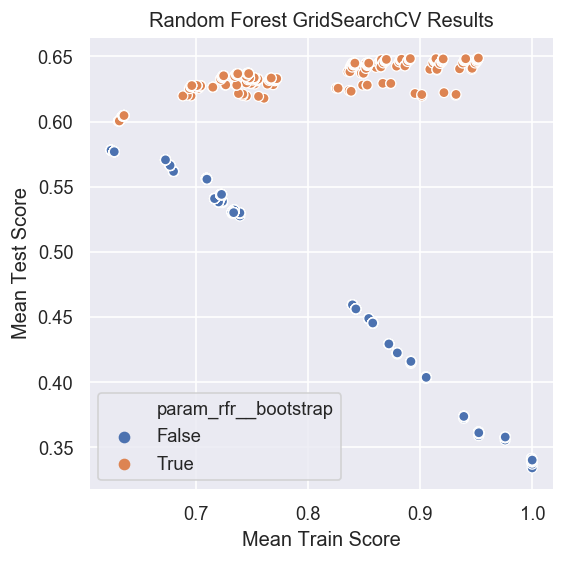

In [118]:
#Plot gridsearch test results vs. train results
fig=plt.figure(figsize=(5, 5), dpi=120)
sns.scatterplot(rfr_cv_results.mean_train_score, rfr_cv_results.mean_test_score,
               hue=rfr_cv_results.param_rfr__bootstrap)
plt.xlabel("Mean Train Score")
plt.ylabel("Mean Test Score")
plt.title("Random Forest GridSearchCV Results")
plt.show()

Looking at the scatterplot of GridSearch results comparing the mean test scores against train scores shows some interesting insights. First, the bootstrap parameter, which determines whether bootstrap samples are used in tree-building, makes a big difference in terms of overfitting. With bootstrap set to False the mean test score rapidly decreases as the mean training score increases (the blue dots on the plot). 

Focusing on the results where bootstrap was set to True, overfitting is not as strong, but it is still occurring. We can see that the test scores for the orange dots mostly stays between 0.62 and 0.65, even as the training score rises from .7 to .95. This tells me there is a "sweet spot" in the cluster of results around .63 test score and .7-.75 training score. There is no need to use a model with a Train score in the .90's if it only results in a .01 or .02 increase in test scoring. Next I will inspect the parameters of the models in this "sweet spot" range and check what they have in common.

In [125]:
rfr_cv_results.loc[(rfr_cv_results['mean_test_score'] > 0.62) & (rfr_cv_results['mean_train_score'] < 0.79),
                   ['param_rfr__bootstrap', 'param_rfr__max_depth', 'param_rfr__min_samples_leaf',
                   'param_rfr__min_samples_split', 'param_rfr__n_estimators', 'mean_train_score', 
                   'mean_test_score','rank_test_score']].sort_values('mean_test_score', ascending=False)

,param_rfr__bootstrap,param_rfr__max_depth,param_rfr__min_samples_leaf,param_rfr__min_samples_split,param_rfr__n_estimators,mean_train_score,mean_test_score,rank_test_score
263,True,30,1,50,70,0.746438,0.637062,161
383,True,40,1,50,70,0.746443,0.637042,162
267,True,30,1,50,150,0.747007,0.637008,163
143,True,20,1,50,70,0.745423,0.636998,164
387,True,40,1,50,150,0.747014,0.636992,166
264,True,30,1,50,90,0.746664,0.636971,168
384,True,40,1,50,90,0.746669,0.636955,169
144,True,20,1,50,90,0.745593,0.636906,170
268,True,30,1,50,170,0.746965,0.636865,171
147,True,20,1,50,150,0.745934,0.636856,172


Inspecting the table above I see a promising model about 4 records from the top, where rank_test_score = 164. This model has a mean test score just a fraction under 0.637 (the best model with these filters is at 0.637062) and a train score of 0.745. The original "best estimator" found by GridSearchCV had a train score of 0.952 and a test score of 0.659, so this is very close in terms of test score while bringing the training score much closer, indicating significantly less overfitting.

The parameters of this model are a max depth of 20 (half the depth of the best estimator model), min leaf samples at 1 (unchanged), min samples split at 50 (much higher than the best estimator model), and only 70 trees (n estimators) instead of 190 for the best estimator model. In short this model sacrifices only 0.022 test scoring for a much simpler model which is less likely to have overfit. I will now train a model with these parameters to use going forward. 

In [126]:
#Create new random forest classifier
rfr_v2 = RandomForestRegressor(n_jobs=-1, random_state=17, min_samples_split=50, n_estimators=70, max_depth=20)
#Create new pipeline using new classifier
pipeline_rfr_v2 = Pipeline([("Scaler", scaler), ("rfr_v2", rfr_v2)])

In [127]:
#Fit new model
rfr_fit_model_v2 = pipeline_rfr_v2.fit(X_train, y_train['log_price'])

In [128]:
#Calculate R^2 on train and test sets for lasso_vars model
rfr_v2_r2_train = rfr_fit_model_v2.score(X_train, y_train['log_price'])
rfr_v2_r2_test = rfr_fit_model_v2.score(X_test, y_test['log_price'])

In [129]:
#Calculate Mean Squared Error on test and train sets - all vars
x_train_pred = rfr_fit_model_v2.predict(X_train)
x_test_pred = rfr_fit_model_v2.predict(X_test)

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [130]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'RF_AllVars_v2', 'R2_train':rfr_v2_r2_train, 'R2_test':rfr_v2_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [132]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']].sort_values('MSE_test')

,Model,R2_train,R2_test,MSE_train,MSE_test
0,RF_AllVars,0.952252,0.659478,0.019925,0.146362
0,RF_AllVars_v2,0.747018,0.643550,0.105571,0.153208
0,Ridge_LogPrice_AllVars,0.639436,0.634280,0.150465,0.157192
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333
0,RF_LassoVars,0.667029,0.611334,0.138950,0.167055
0,Ridge_LogPrice_LassoVars,0.596307,0.593996,0.168463,0.174507
0,Lasso_LogPrice,0.566076,0.563760,0.181078,0.187503
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468


### View Random Forest Feature Importances

#### All variable model

In [136]:
rfr_fit_model_v2.named_steps

{'Scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'rfr_v2': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)}

In [137]:
features = list(X_vars)
importances = rfr_fit_model_v2.named_steps['rfr_v2'].feature_importances_
indices = np.argsort(importances)

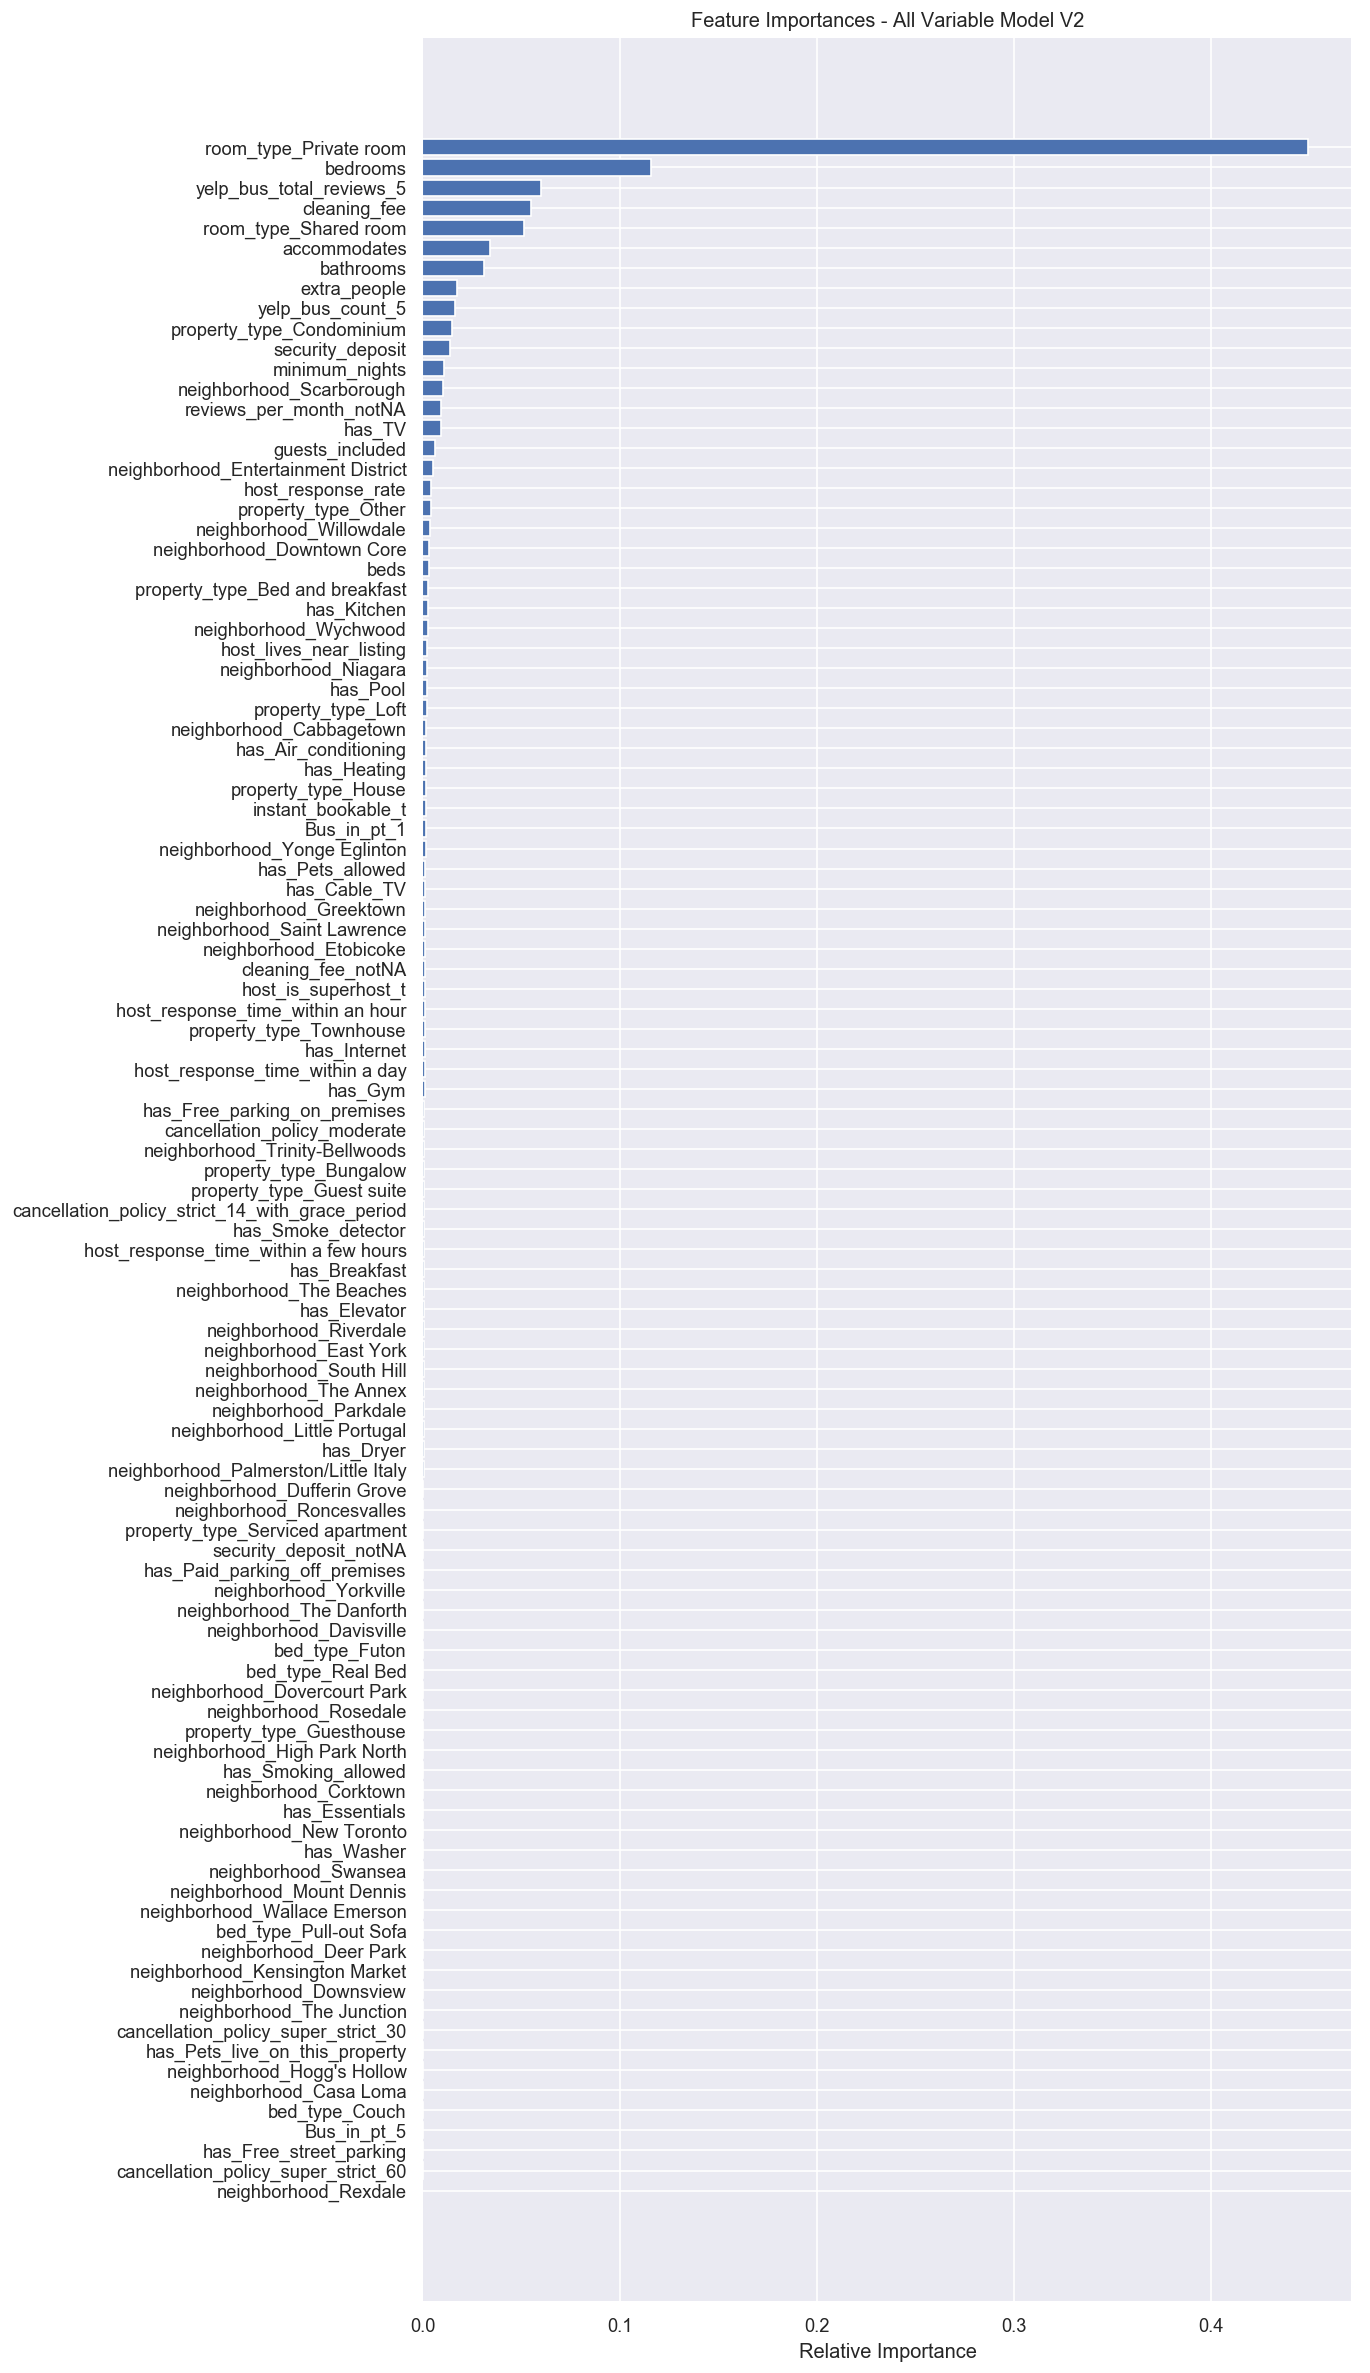

In [138]:
fig=plt.figure(figsize=(10, 25), dpi=120)
plt.title('Feature Importances - All Variable Model V2')
plt.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [139]:
features_df = pd.DataFrame(features)
features_df.rename(columns={0:'Parameter'}, inplace=True)

In [140]:
importances_df = pd.DataFrame(importances)
importances_df.rename(columns={0:'RF_Imp'}, inplace=True)

In [141]:
rf_vars = features_df.join(importances_df)

#### Lasso Variable Model

In [142]:
lasso_importances = rfr_lasso_vars.best_estimator_.steps[1][1].feature_importances_
indices = np.argsort(lasso_importances)

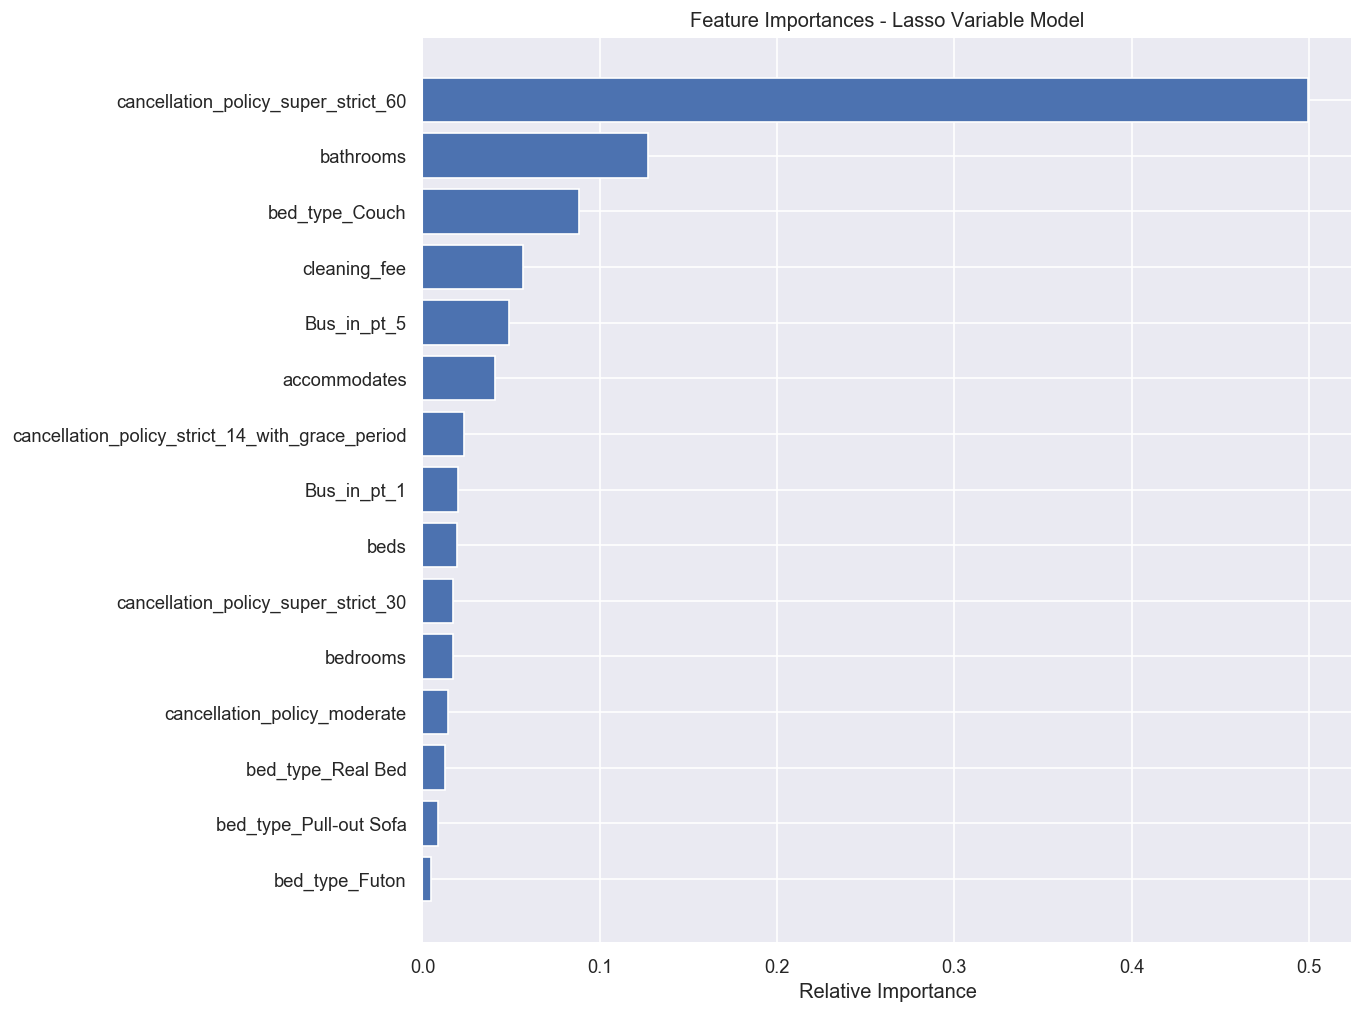

In [143]:
fig=plt.figure(figsize=(10, 10), dpi=120)
plt.title('Feature Importances - Lasso Variable Model')
plt.barh(range(len(indices)), lasso_importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [144]:
features_df_2 = pd.DataFrame(features)
features_df_2.rename(columns={0:'Parameter'}, inplace=True)

In [145]:
importances_df_2 = pd.DataFrame(lasso_importances)
importances_df_2.rename(columns={0:'RF_Imp_Lasso'}, inplace=True)

In [146]:
rf_vars_lasso = features_df_2.join(importances_df_2)

In [147]:
rf_vars = rf_vars.merge(rf_vars_lasso, on='Parameter', how='left')

In [148]:
rf_vars.sort_values('RF_Imp', ascending=False)

,Parameter,RF_Imp,RF_Imp_Lasso
97,room_type_Private room,0.449200,NaN
8,bedrooms,0.116145,0.017237
102,yelp_bus_total_reviews_5,0.060046,NaN
14,cleaning_fee,0.055274,0.056606
98,room_type_Shared room,0.051670,NaN
2,accommodates,0.034344,0.041009
3,bathrooms,0.031188,0.127348
16,extra_people,0.017611,NaN
101,yelp_bus_count_5,0.016705,NaN
88,property_type_Condominium,0.014734,NaN


The table above compares the feature importances between the two Random Forest Regressor models, sorted by the importance score in the "all variables" model. There are some interesting differences:

 - Having a Private Room or a Shared Room as the Room Type ranks very highly in importance in the all-variables model, but these were excluded by Lasso. 
 - Same with total number of Yelp business reviews and number of businesses within .5 miles
 - Charging a cleaning fee and the number of bathrooms rankes fairly high in both models. 
 - Having a super strict 60 day cancellation policy ranks highest in the Lasso-variables model, but very low in the all-variables model. 
 
For my next step I will try running Ridge one more time, this time with the lasso variables plus a few of the "most important" variables from the random forest model with all variables. 

### Run Ridge with Lasso variables plus RF important variables

In [149]:
#Initialize GridSearchCV
alphas = np.arange(0.01, 3, 0.01)
search_space = [{"Ridge__alpha" : alphas}]
gridsearch_ridge_lasso_plus = GridSearchCV(pipeline_ridge, search_space, cv=5, verbose=0, n_jobs=-1)

In [150]:
plus_vars = ['room_type_Private room', 'yelp_bus_total_reviews_5', 'room_type_Shared room',
             'yelp_bus_count_5', 'extra_people', 'security_deposit']
lasso_vars_plus = lasso_vars + plus_vars

In [151]:
#Model code - do not run again, takes a few minutes - load the saved model instead
#...using code below
#best_ridge_LassoVars_plus = gridsearch_ridge_lasso_plus.fit(X_train[lasso_vars_plus], y_train['log_price'])

In [152]:
#Save model to disk for later re-use
#filename5 = "best_ridge_LassoVars_plus.sav"
#pickle.dump(best_ridge_LassoVars_plus, open(filename5, 'wb'))

In [154]:
#Read in model from saved pickle file
filename5 = "best_ridge_LassoVars_plus.sav"
best_ridge_LassoVars_plus = pickle.load(open(filename5, 'rb'))

In [155]:
best_ridge_LassoVars_plus.best_estimator_.get_params()['Ridge__alpha']

2.9899999999999998

In [156]:
#Calculate R^2 on train and test sets
ridge_r2_train = best_ridge_LassoVars_plus.best_estimator_.score(X_train[lasso_vars_plus], y_train['log_price'])
ridge_r2_test = best_ridge_LassoVars_plus.best_estimator_.score(X_test[lasso_vars_plus], y_test['log_price'])

In [157]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = best_ridge_LassoVars_plus.best_estimator_.predict(X_train[lasso_vars_plus])
x_test_pred = best_ridge_LassoVars_plus.best_estimator_.predict(X_test[lasso_vars_plus])

mse_train = mean_squared_error(y_train['log_price'], x_train_pred)
mse_test = mean_squared_error(y_test['log_price'], x_test_pred)

In [158]:
scores_df = scores_df.append(pd.DataFrame([{'Model':'Ridge_LogPrice_LassoVars_Plus', 'R2_train':ridge_r2_train, 'R2_test':ridge_r2_test, 
                          'MSE_train':mse_train, 'MSE_test':mse_test}]))

In [159]:
scores_df[['Model', 'R2_train', 'R2_test', 'MSE_train', 'MSE_test']].sort_values('MSE_test', ascending = False)

,Model,R2_train,R2_test,MSE_train,MSE_test
0,OLS_RawPrice,0.492882,0.500271,4468.039645,4623.686468
0,Lasso_LogPrice,0.566076,0.563760,0.181078,0.187503
0,Ridge_LogPrice_LassoVars,0.596307,0.593996,0.168463,0.174507
0,Ridge_LogPrice_LassoVars_Plus,0.599280,0.595871,0.167222,0.173701
0,RF_LassoVars,0.667029,0.611334,0.138950,0.167055
0,OLS_LogPrice,0.639501,0.633953,0.150438,0.157333
0,Ridge_LogPrice_AllVars,0.639436,0.634280,0.150465,0.157192
0,RF_AllVars_v2,0.747018,0.643550,0.105571,0.153208
0,RF_AllVars,0.952252,0.659478,0.019925,0.146362


Ridge_LogPrice_LassoVars_Plus is the new model, Ridge_LogPrice_LassoVars is the older model. Adding the handful of extra variables does not show much improvement over the Ridge regression model with just the Lasso Variables. Test R2 goes from 0.594 to 0.596. Test MSE goes from 0.174 to 0.173. It is not worth the added complexity to add those variables. 

To this point the most accurate model with the least number of variables is still Random Forest with the Lasso Variables (model RF_LassoVars in the table above). If my goal was to produce a model for explanatory purposes, to better understand what factors impact price, this is the model I would use, because it is the simplest to understand. All it takes is exponentiating the coefficients to return interpretable values, and with only 15 variables is is easier to return actionable insights. 

However at this point my ultimate goal is to produce the most accurate, predictive model. To that end the best model with the least amount of overfitting to this point is "RF_AllVars_V2". This is the random forest model with all variables included, but using slightly less than optimal parameters to reduce overfitting. Up next I will use this model to predict price, then use the delta between predicted and actual price to predict utilization. 

## Predicting Utilization Rate

### Produce Baseline Utilization Rate Prediction Model

Next I will calculate the difference between the predicted price from my best model found above, vs. the actual price. I will then feed this as a single variable into a regression model to predict utilization, to see how strong of a predictor it is and test my theory that an over-priced listing will turna way customers. 

In [160]:
#Predict price using random forest model V2
price_preds = rfr_fit_model_v2.predict(X)

In [161]:
#Join predictions with Utilization Prediction dataframe
#This is the dataframe I created earlier with just the variables 
#... that showed some relationship to Utilization Rate
abb_Util_predict = abb_Util_predict.join(pd.DataFrame(price_preds))

In [162]:
#Rename new column
abb_Util_predict.rename(columns={0:"log_price_pred"}, inplace=True)

In [163]:
#Convert price predictions from log via exp function
abb_Util_predict['price_pred'] = np.exp(abb_Util_predict.log_price_pred)

In [164]:
#Find the difference between price and predicted price
abb_Util_predict['price_delta'] = abb_Util_predict.price - abb_Util_predict.price_pred

In [165]:
#View top 5 records price, price predictions, and the delta
abb_Util_predict[['price', 'log_price_pred', 'price_pred', 'price_delta']].head()

,price,log_price_pred,price_pred,price_delta
0,470.0,5.967634,390.580538,79.419462
1,69.0,4.023383,55.889868,13.110132
2,65.0,4.020693,55.739711,9.260289
3,99.0,4.559321,95.518567,3.481433
4,70.0,4.106396,60.727479,9.272521


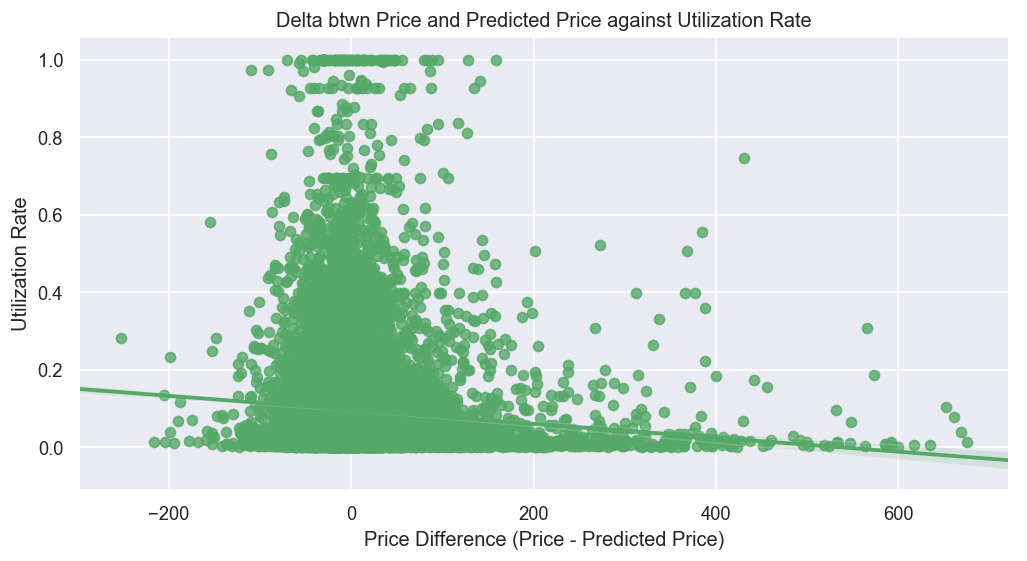

In [188]:
fig=plt.figure(figsize=(10, 5), dpi=120)
sns.regplot(abb_Util_predict.price_delta, abb_Util_predict.Utilization_Rate, color='g')
#sns.regplot(abb_Util_predict.Utilization_Rate[abb_Util_predict['Utilization_Rate'] < 0.3], 
#            abb_Util_predict.price_delta[abb_Util_predict['Utilization_Rate'] < 0.3], 
#            color='g')
plt.xlabel('Price Difference (Price - Predicted Price)')
plt.ylabel('Utilization Rate')
plt.title('Delta btwn Price and Predicted Price against Utilization Rate')
plt.show()

Plotting the price delta against Utilization Rate shows a very flat trend line. However there does appear to be a pattern where the largest price differences occur at the lower end of Utilization Rate. 

In [190]:
#Create X and y, test/train split for simple utilization model
X_util_simple = abb_Util_predict.price_delta
y_util = abb_Util_predict.Utilization_Rate

X_train_util, X_test_util, y_train_util, y_test_util = train_test_split(X_util_simple, y_util,
                                                                       test_size = 0.3,
                                                                       random_state = 17)

In [191]:
print(X_train_util.shape)
print(y_train_util.shape)
print(X_test_util.shape)
print(y_test_util.shape)

(11207,)
(11207,)
(4804,)
(4804,)


In [192]:
#Now time to predict using simple OLS
#I will re-use the OLS pipeline I built earlier, pipeline_ols, 
#... which uses MinMaxScaler and LinearRegression
simple_util_model = pipeline_ols.fit(X_train_util.values.reshape(-1, 1), 
                                     y_train_util.values.reshape(-1, 1))

In [193]:
#Find R^2 on train and test sets
simple_util_r2_train = pipeline_ols.score(X_train_util.values.reshape(-1, 1), 
                                   y_train_util.values.reshape(-1, 1))

simple_util_r2_test = pipeline_ols.score(X_test_util.values.reshape(-1, 1), 
                                   y_test_util.values.reshape(-1, 1))

print(simple_util_r2_train)
print(simple_util_r2_test)

0.005626593532738089
0.006523175182248652


In [194]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = simple_util_model.predict(X_train_util.values.reshape(-1, 1))
x_test_pred = simple_util_model.predict(X_test_util.values.reshape(-1, 1))

mse_train = mean_squared_error(y_train_util.values.reshape(-1, 1), x_train_pred)
mse_test = mean_squared_error(y_test_util.values.reshape(-1, 1), x_test_pred)

In [195]:
print(mse_train)
print(mse_test)

0.02026369102725809
0.020305798039511214


The initial results are not promising. R2 on the test and training sets are very close to 0. This indicates a simple model predicting Utilization Rate with the delta of the actual and predicted pricing is not good enough. Next I will try predicting Utilization Rate with more variables. 

### Predict Utilization with More Variables

In [197]:
#Perform get_dummies to one-hot encode categorical variables
cat_cols_util = abb_Util_predict[['host_response_time', 'neighborhood', 'host_is_superhost', 'room_type', 'bed_type',
                            'instant_bookable', 'cancellation_policy', 'property_type']].columns

abb_Util_predict_expanded = abb_Util_predict.copy()
abb_Util_predict_expanded = pd.get_dummies(abb_Util_predict, sparse=True, columns=cat_cols_util, drop_first=True)

In [198]:
#Create X and y
X_vars_util = abb_Util_predict_expanded.columns.difference(['id', 'price', 'Utilization_Rate', 'log_price',
                                                      'price_pred', 'log_price_pred'])
X_util = abb_Util_predict_expanded[X_vars_util]

In [199]:
#Create train-test split
X_train_util2, X_test_util2, y_train_util2,  y_test_util2 = train_test_split(X_util, y_util, 
                                                     test_size = 0.3, 
                                                     random_state=17)

In [200]:
util_ols_allVars = pipeline_ols.fit(X_train_util2, y_train_util2)

In [201]:
#Find R^2 on train and test sets
util_r2_train_allVars = pipeline_ols.score(X_train_util2, y_train_util2)

util_r2_test_allVars = pipeline_ols.score(X_test_util2, y_test_util2)

print(util_r2_train_allVars)
print(util_r2_test_allVars)

0.11162865905602948
0.10145340859328654


In [202]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = util_ols_allVars.predict(X_train_util2)
x_test_pred = util_ols_allVars.predict(X_test_util2)

mse_train = mean_squared_error(y_train_util2, x_train_pred)
mse_test = mean_squared_error(y_test_util2, x_test_pred)

print(mse_train)
print(mse_test)

0.01810354365199151
0.0183655070338888


The model has improved. An R^2 of .10 in test is not great, but it is starting to show some relationship. Next I will try limiting the dataset to just listings with a utilization rate above .05. My theory is that listings below that threshold are unrepresentative of the typical listing and have some problem preventing them from being rented. 

### Limit Dataset to Utilization Rate above 5%

In [182]:
abb_Util_predict_threshold = abb_Util_predict_expanded[abb_Util_predict_expanded.Utilization_Rate > .05]

In [183]:
print(abb_Util_predict_expanded.shape)
print(abb_Util_predict_threshold.shape)

(16011, 99)
(6978, 99)


In [184]:
#Create X and y
X_vars_util_threshold = abb_Util_predict_threshold.columns.difference(['id', 'price', 'Utilization_Rate', 'log_price',
                                                      'price_pred', 'log_price_pred'])
X_util_threshold = abb_Util_predict_threshold[X_vars_util_threshold]

y_util_threshold = abb_Util_predict_threshold.Utilization_Rate

In [185]:
#Create train-test split
X_train_util3, X_test_util3, y_train_util3,  y_test_util3 = train_test_split(X_util_threshold, y_util_threshold, 
                                                     test_size = 0.3, 
                                                     random_state=17)

In [186]:
util_ols_allVars_threshold = pipeline_ols.fit(X_train_util3, y_train_util3)

In [187]:
#Find R^2 on train and test sets
util_r2_train_threshold = pipeline_ols.score(X_train_util3, y_train_util3)

util_r2_test_threshold = pipeline_ols.score(X_test_util3, y_test_util3)

print(util_r2_train_threshold)
print(util_r2_test_threshold)

0.09761739451572016
0.0363218886709199


In [203]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = util_ols_allVars_threshold.predict(X_train_util3)
x_test_pred = util_ols_allVars_threshold.predict(X_test_util3)

mse_train = mean_squared_error(y_train_util3, x_train_pred)
mse_test = mean_squared_error(y_test_util3, x_test_pred)

print(mse_train)
print(mse_test)

0.03614515908033918
0.031730569672112775


Limiting the dataset to just records with a utilization rate above 5% did not help the model. This makes intutive sense looking at the scatterplot above as most of the spread in the difference between price and predicted price is found in the lower-utilization records.

Next I will try predicting utilization with two different model types - Ridge Regression and Random Forest. 

### Predicting Utilization with Ridge Regression

In [204]:
#Initialize GridSearchCV object... pipeline_ridge, search_space were defined previously
gridsearch_ridge_Util = GridSearchCV(pipeline_ridge, search_space, cv=5, verbose=0, n_jobs=-1)

In [205]:
#Fit model - do not run again, load saved model instead
#best_ridge_Util = gridsearch_ridge_Util.fit(X_train_util2, y_train_util2)

In [207]:
#Save model to disk for later re-use
#filename6 = "best_ridge_Utill_model.sav"
#pickle.dump(best_ridge_Util, open(filename6, 'wb'))

In [ ]:
#Read in model from saved pickle file
filename6 = "best_ridge_Utill_model.sav"
best_ridge_Util = pickle.load(open(filename6, 'rb'))

In [208]:
best_ridge_Util.best_estimator_.get_params()['Ridge__alpha']

2.9899999999999998

In [209]:
#Calculate R^2 on train and test sets
ridge_r2_train_util = best_ridge_Util.best_estimator_.score(X_train_util2, y_train_util2)
ridge_r2_test_util = best_ridge_Util.best_estimator_.score(X_test_util2, y_test_util2)

In [211]:
print(ridge_r2_train_util)
print(ridge_r2_test_util)

0.1119753254102539
0.10207797715294387


In [210]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = best_ridge_Util.best_estimator_.predict(X_train_util2)
x_test_pred = best_ridge_Util.best_estimator_.predict(X_test_util2)

mse_train = mean_squared_error(y_train_util2, x_train_pred)
mse_test = mean_squared_error(y_test_util2, x_test_pred)

In [212]:
print(mse_train)
print(mse_test)

0.018096479163092406
0.01835274139837782


Ridge regression performed almost identically to standard OLS, the scores on test and train did not change significantly. 

### Predicting Utilization with Random Forest

In [221]:
#Initialize new GridSearchCV... I will re-use rfr (RandomForestRegressor object) and pipeline_rfr from earlier
n_estimators = np.arange(20, 120, 20)
max_depth = np.arange(5, 20, 5)
min_samples_split = [5, 10, 20, 50]
min_samples_leaf = [5, 10, 20, 50]

search_space_rfr_util = [{"rfr__n_estimators" : n_estimators,
                         "rfr__max_depth" : max_depth,
                         "rfr__min_samples_split" : min_samples_split,
                         "rfr__min_samples_leaf" : min_samples_leaf}]

In [222]:
gridsearch_rfr_util = GridSearchCV(pipeline_rfr, search_space_rfr_util, cv=5, verbose=0, n_jobs=-1)

In [224]:
#Fit random forest
#Do not run again, takes a long time - load saved model instead
rfr_util = gridsearch_rfr_util.fit(X_train_util2, y_train_util2)

In [225]:
#Save model to disk
#filename7 = "rfr_util.sav"
#with open(filename7, 'wb') as file:
#    pickle.dump(rfr_util, file)

In [ ]:
#Import saved model
filename7 = "rfr_util.sav"
with open(filename7, 'rb') as file:
    rfr_util = pickle.load(file)

In [226]:
rfr_util.best_params_

{'rfr__max_depth': 15,
 'rfr__min_samples_leaf': 10,
 'rfr__min_samples_split': 10,
 'rfr__n_estimators': 100}

In [227]:
rfr_util.best_score_

0.13569897268635336

In [228]:
#Calculate R^2 on train and test sets
rfr_r2_train_util = rfr_util.best_estimator_.score(X_train_util2, y_train_util2)
rfr_r2_test_util = rfr_util.best_estimator_.score(X_test_util2, y_test_util2)

In [229]:
print(rfr_r2_train_util)
print(rfr_r2_test_util)

0.36989388649945965
0.12758693625995343


In [230]:
#Calculate Mean Squared Error on test and train sets
x_train_pred = rfr_util.best_estimator_.predict(X_train_util2)
x_test_pred = rfr_util.best_estimator_.predict(X_test_util2)

mse_train = mean_squared_error(y_train_util2, x_train_pred)
mse_test = mean_squared_error(y_test_util2, x_test_pred)

In [231]:
print(mse_train)
print(mse_test)

0.012840524007700058
0.017831360568059906


The R^2 and MSE improved slightly on the test dataset, but we see a significant jump in the training set. The increase is suspiciously large and indicates this random forest overfit, similar to the random forest performed earlier to predict Price. 

The random forest model only showed a slight improvement in test scoring so I will stick with the Ridge regression variant and view the coefficients. I will use these to make recommendations to my customers about which variables have the strongest impact on Utilization Rate. 

### Inspect coefficients of Ridge model for explanatory purposes

In [256]:
coefficients_ridge_util = pd.DataFrame({"Feature" : X_train_util2.columns,
                                       "Coefficients" : np.transpose(best_ridge_Util.best_estimator_.named_steps.Ridge.coef_)})

In [257]:
coefficients_ridge_util.sort_values("Coefficients", ascending=False)

,Feature,Coefficients
88,reviews_per_month_notNA,0.050257
35,minimum_nights,0.050171
62,neighborhood_Saint Lawrence,0.050055
26,host_is_superhost_t,0.045967
42,neighborhood_Downsview,0.043481
54,neighborhood_New Toronto,0.033146
9,beds,0.028426
34,instant_bookable_t,0.025938
46,neighborhood_Entertainment District,0.023694
76,neighbourhood_notNA,0.022717
